# Загрузка датасета

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zaytsevpavel1376","key":"c8168b07601ba2f9b91269f7e2a1949b"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d cherngs/heart-disease-cleveland-uci

Dataset URL: https://www.kaggle.com/datasets/cherngs/heart-disease-cleveland-uci
License(s): reddit-api
  0% 0.00/3.33k [00:00<?, ?B/s]
100% 3.33k/3.33k [00:00<00:00, 7.59MB/s]


In [5]:
! unzip  '/content/heart-disease-cleveland-uci.zip' -d '/content/heart-disease-cleveland-uci'

Archive:  /content/heart-disease-cleveland-uci.zip
  inflating: /content/heart-disease-cleveland-uci/heart_cleveland_upload.csv  


# Подкючение библиотек


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# Посмотрим на датасет

In [7]:
start_data = pd.read_csv('/content/heart-disease-cleveland-uci/heart_cleveland_upload.csv')
#start_data = pd.read_csv('/content/heart-disease-cleveland-uci/heart_cleveland_upload.csv', sep=',')
start_data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


# Анализ предметной области

## О датасете
Набор данных содержит информацию о пациентах и наличие у них болезни сердца

## Задача
Задача формулируется как задача бинарной классификации (0 - нет болезни сердца, 1 - есть)

### Признаки датасета

1. age: возраст в годах

2. sex: пол (1 = мужской; 0 = женский)

3. ср: тип боли в груди
* Значение О: типичная стенокардия
* Значение 1: атипичная стенокардия
* Значение 2: неангинальная боль
* Значение 3: бессимптомная

4. trestbps: артериальное давление в состоянии покоя (в мм рт. ст. при поступлении в больницу)
5. chol: сывороточный холестерин в мг/дл
6. fbs: (уровень сахара в крови натощак > 120 мг/дл) (1 = правда; 0 = ложь)
7. restecg: результаты электрокардиографии в состоянии покоя
* Значение О: норма
* Значение 1: наличие аномалии зубца ST-T (инверсия зубца Т и/или подъем или депрессия ST > 0,05 мВ)
* Значение 2: указание на вероятную или определенную гипертрофию левого желудочка по критериям Эстеса

8. thalach: максимальная достигнутая частота сердечных сокращений

9. exang: стенокардия, вызванная физической нагрузкой (1 = да; 0 = нет)

10. oldpeak = депрессия ST, вызванная физической нагрузкой, по сравнению с состоянием покоя

11. slope: наклон пикового сегмента ST нагрузки
* Значение О: восходящий
* Значение 1: плоский
* Значение 2: нисходящий

12. са: количество крупных сосудов (0-3), окрашенных флюороскопией

13. thal: 0 = нормальный; 1 = фиксированный дефект; 2 = обратимый дефект
N MeTka

### Целевая переменная

14. condition: 0 = нет заболевания, 1 = заболевание

## Информация о признаках

In [8]:
print("Кол-во уникальных значений")
print(start_data.nunique(), '\n')

print("Типы переменных о датафрейме, кол-во пропущенных значений")
print(start_data.info())

Кол-во уникальных значений
age           41
sex            2
cp             4
trestbps      50
chol         152
fbs            2
restecg        3
thalach       91
exang          2
oldpeak       40
slope          3
ca             4
thal           3
condition      2
dtype: int64 

Типы переменных о датафрейме, кол-во пропущенных значений
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64

Видно, что датасет уже частично предобработан. Все переменные числовые, нет пропущенных значений и повторяющихся строк.

# Предобработка данных

## Кодирование категориальных переменных

Несмотря на то, что все данные числовые, некоторые из переменных до предобработки были категориальными. Например sex, cp, restecg, и тд. Для чего нам это надо знать: в зависимости от типа категориальной переменной (порядок имеет значение или нет) кодировать переменные можно по разному. А именно: если для переменной значения нельзя сравнивать, то стоит применить OneHot кодирование (каждое значение = отдельный столбец). Иначе, можно оставить данные как есть (сейчас все категориальные переменные закодированны Label Encoder).



In [9]:
from  sklearn.preprocessing import OneHotEncoder

categ_col_unorder = ['cp']

data = start_data.copy()
oneHotEncode = OneHotEncoder()
data_categ_encode = pd.DataFrame(oneHotEncode.fit_transform(data[categ_col_unorder]).toarray(), columns = oneHotEncode.get_feature_names_out())

data_categ_encode

,cp_0,cp_1,cp_2,cp_3
0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0
...,...,...,...,...
292,0.0,0.0,0.0,1.0
293,0.0,0.0,0.0,1.0
294,0.0,0.0,0.0,1.0
295,0.0,0.0,0.0,1.0


## Некатегориальные переменные

Посмотрим на остальные переменные. Некатегориальные. (Отмечу, что я ничего не делал с бинарными категориальными переменными, т.к. без разницы как их кодировать, в несколько столбцов или в один). Посмотрим на распределение некатегориальных переменных через график "ящик с усами"

In [10]:
data = data.rename(columns={'condition': 'Target'})

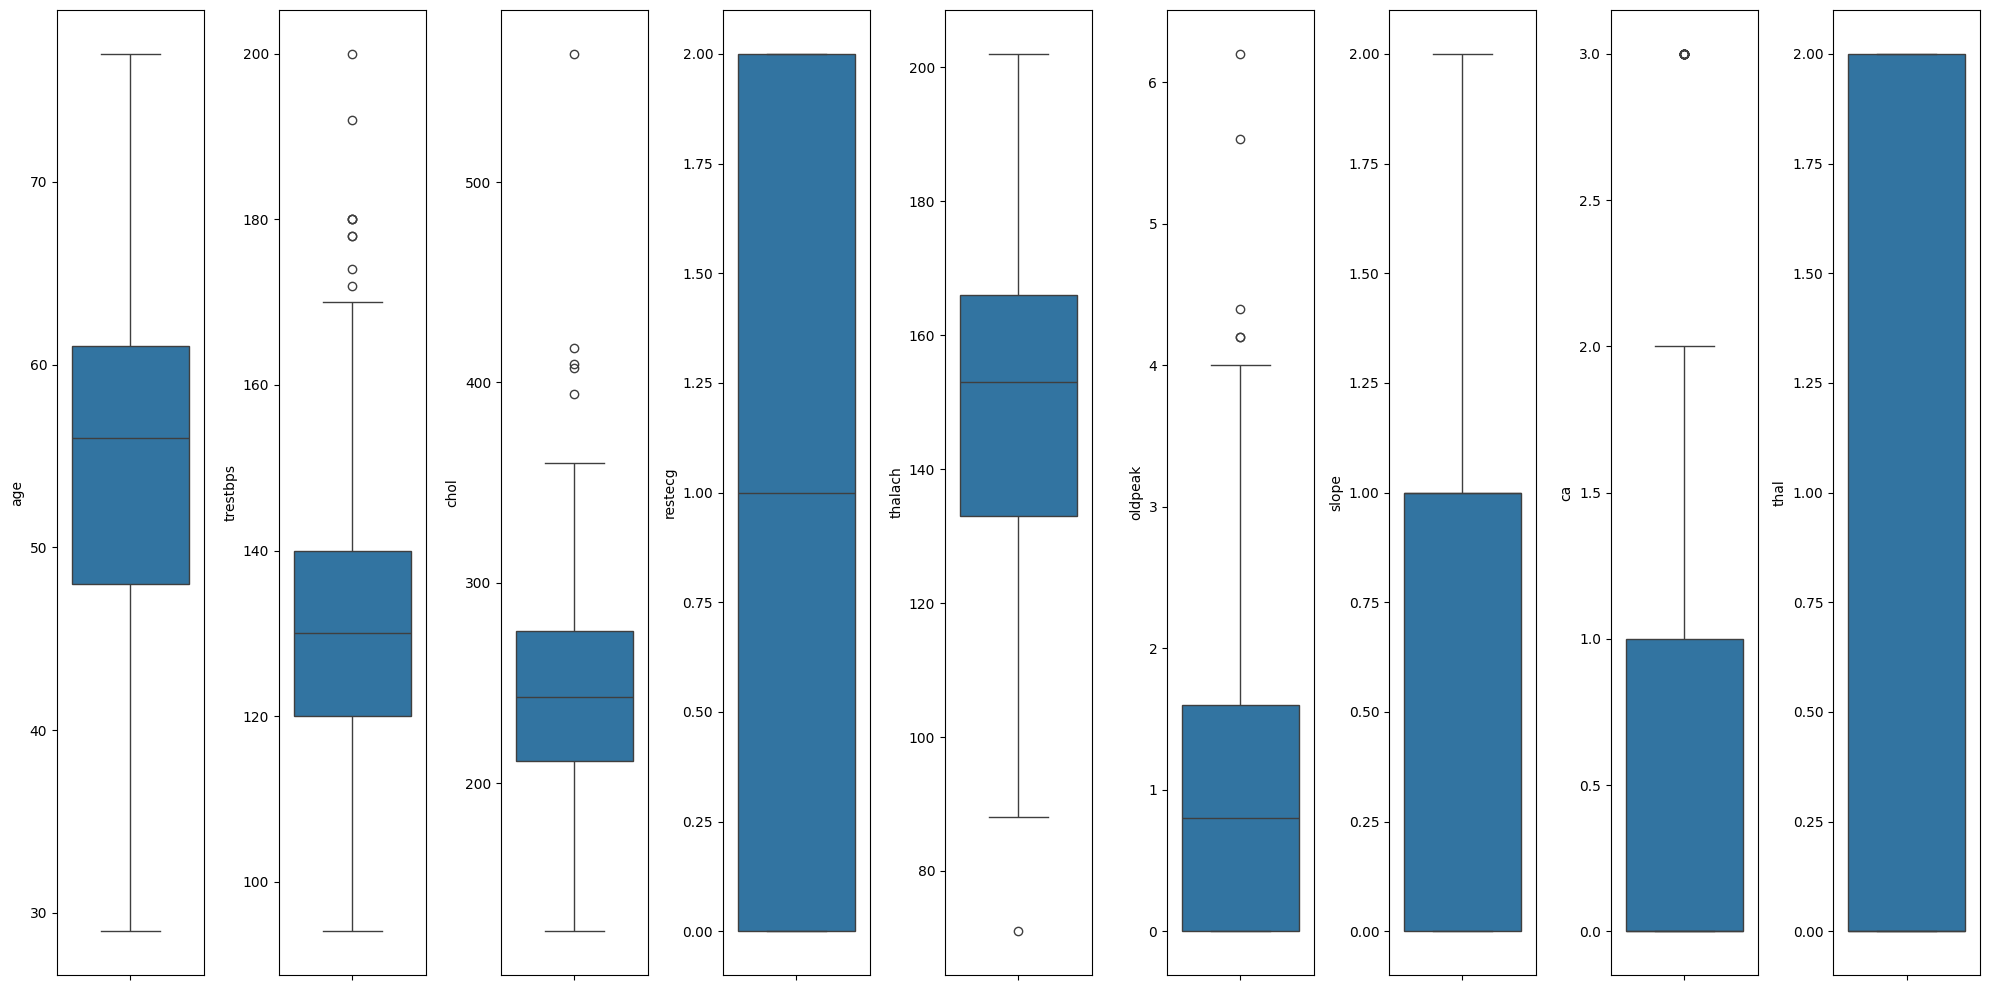

In [11]:
import seaborn as sns

y = pd.DataFrame(data['Target'])
data_cont = data.drop(['sex', 'cp', 'fbs', 'exang'], axis=1)
data_cont.drop(['Target'], axis=1, inplace=True)

fig = plt.figure(figsize=(20, 10))
for ind, col in enumerate(data_cont.columns):
  ax = fig.add_subplot(1, len(data_cont.columns), ind+1)
  sns.boxplot(data_cont[col], ax=ax)

fig.tight_layout()

### По графику видно, что данные имеют много выбросов. => лучше делать нормировку по квартилям.

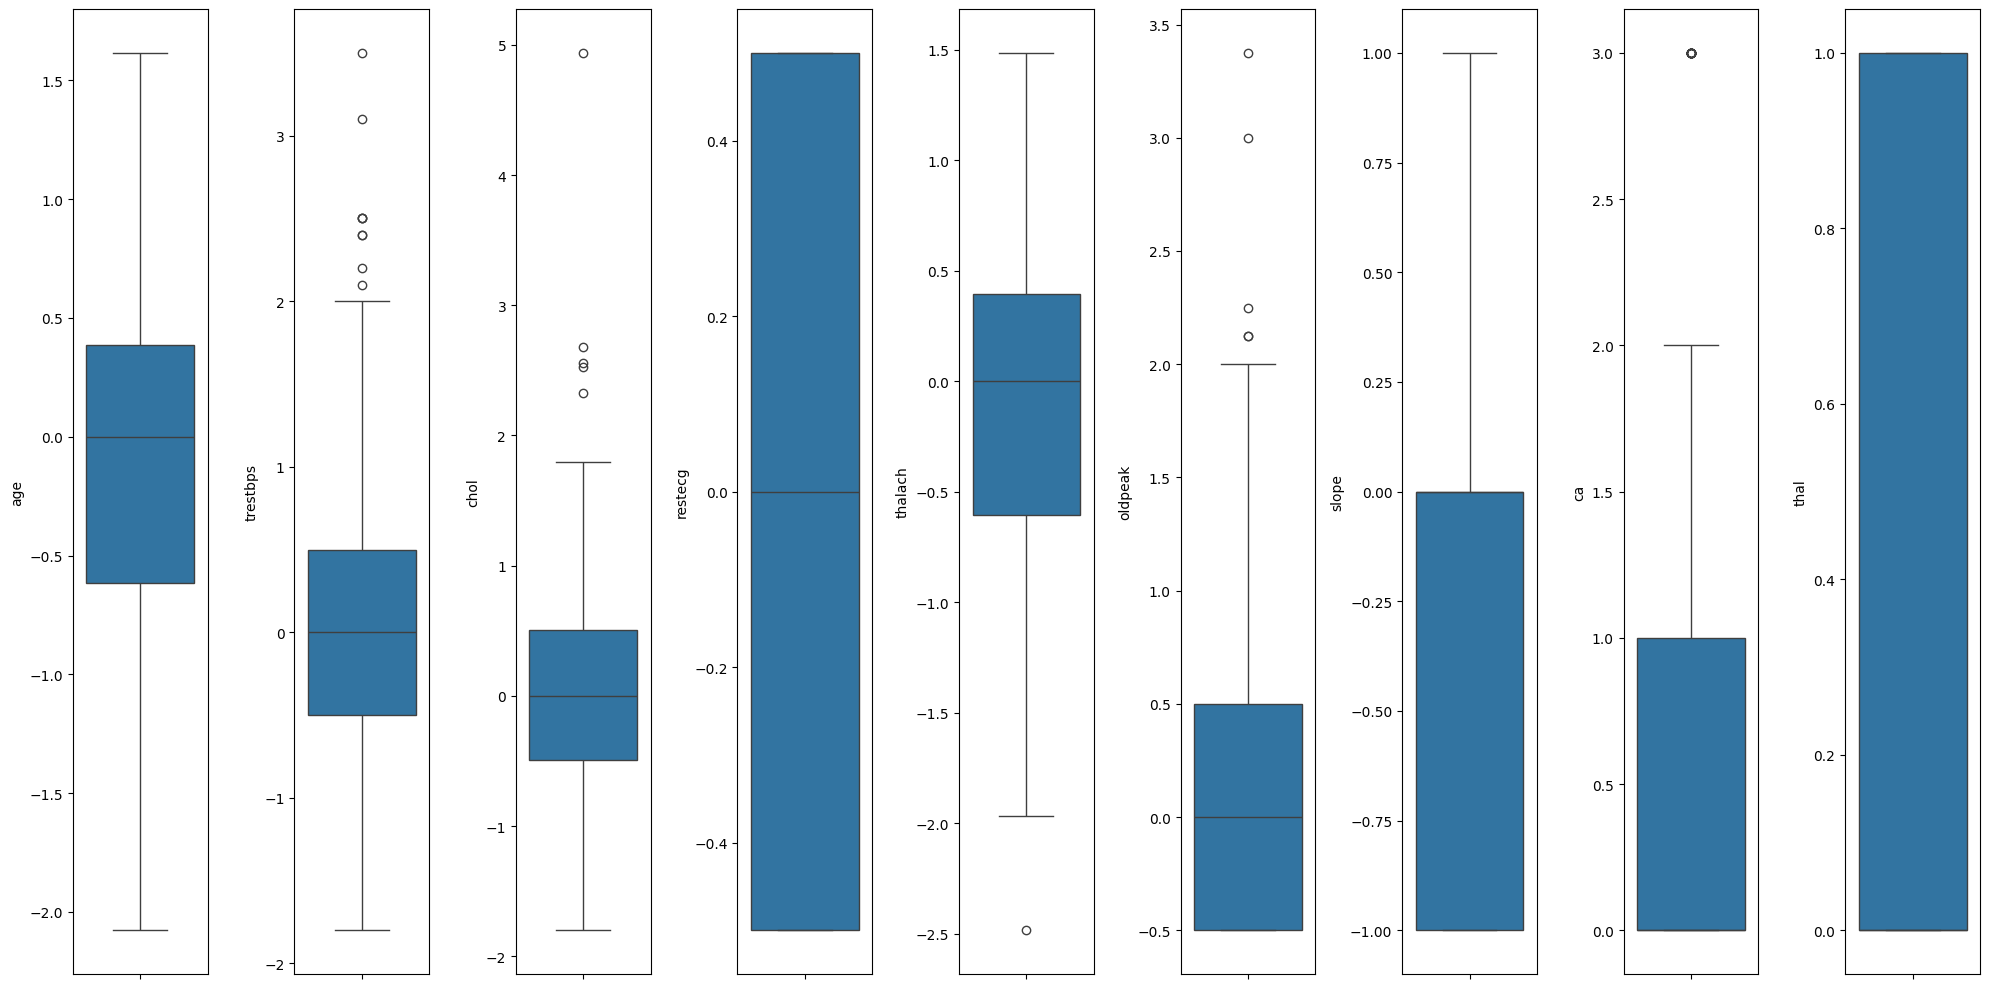

In [12]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
data_cont_sd = pd.DataFrame(scaler.fit(data_cont).transform(data_cont), columns=scaler.get_feature_names_out())

fig = plt.figure(figsize=(20, 10))
for ind, col in enumerate(data_cont_sd.columns):
  ax = fig.add_subplot(1, len(data_cont_sd.columns), ind+1)
  sns.boxplot(data_cont_sd[col], ax=ax)

fig.tight_layout()

## Посмотрим корреляцию между признаками, чтобы в случае высокой зависимости между переменными выкинуть лишние признаки.

In [13]:
corr = data_cont_sd.corr()

cmap = sns.diverging_palette(5, 250, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .format(precision=3)\
    .set_properties(**{'max-width': '80px', 'font-size': '12pt'})\
    .set_caption("Корреляция непрерывных признаков")\
    .set_table_styles(magnify())

,age,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal
age,1.000,0.290,0.203,0.150,-0.395,0.197,0.159,0.362,0.121
trestbps,0.290,1.000,0.132,0.149,-0.049,0.191,0.121,0.098,0.131
chol,0.203,0.132,1.000,0.165,-0.000,0.039,-0.009,0.116,0.023
restecg,0.150,0.149,0.165,1.000,-0.072,0.114,0.135,0.129,0.014
thalach,-0.395,-0.049,-0.000,-0.072,1.000,-0.348,-0.389,-0.269,-0.258
oldpeak,0.197,0.191,0.039,0.114,-0.348,1.000,0.579,0.294,0.337
slope,0.159,0.121,-0.009,0.135,-0.389,0.579,1.000,0.110,0.260
ca,0.362,0.098,0.116,0.129,-0.269,0.294,0.110,1.000,0.249
thal,0.121,0.131,0.023,0.014,-0.258,0.337,0.260,0.249,1.000


### Видно, что данные об учебной программе не сильно коррелируют между собой. Наибольшая корреляция наблюдается между признаками slope и oldpeak. Коне  Не будем уменьшать количество атрибутов. Однако через РСА посмотрим вклад атрибутов в общий разброс:

In [14]:
from sklearn.decomposition import PCA

data_cont_pca = data_cont_sd.copy()

n_features_rsa = len(data_cont_pca.columns)
pca = PCA(n_components=n_features_rsa)
pca.fit(data_cont_pca)
print(pca.explained_variance_ratio_)
data_cont_pca = pd.DataFrame(pca.transform(data_cont_pca))

[0.30448988 0.16679908 0.14721195 0.11716339 0.0898817  0.05220633
 0.04886994 0.03774553 0.03563221]


### Видно, что вклад в разброс есть от каждой переменной и нет выделяющихся признаков, с таким вкладом, которым можно было бы пренебречь

In [15]:
X = pd.concat([data_cont_sd, data[['sex', 'fbs', 'exang']], data_categ_encode], axis=1)
#X_features, y.features = X.columns, y.columns
pd.concat([X, y], axis=1)

,age,trestbps,chol,restecg,thalach,oldpeak,slope,ca,thal,sex,fbs,exang,cp_0,cp_1,cp_2,cp_3,Target
0,1.000000,1.5,-0.138462,0.5,-0.666667,-0.4375,0.0,1.0,0.0,1,1,0,1.0,0.0,0.0,0.0,0
1,1.000000,0.5,-0.061538,-0.5,-0.060606,0.6250,-1.0,2.0,0.0,0,0,0,1.0,0.0,0.0,0.0,0
2,0.769231,1.0,-0.261538,-0.5,-1.181818,1.1250,1.0,0.0,0.0,0,0,0,1.0,0.0,0.0,0.0,0
3,0.692308,0.4,0.600000,0.5,0.636364,0.3750,0.0,1.0,0.0,1,1,0,1.0,0.0,0.0,0.0,1
4,0.615385,-1.0,-0.492308,0.5,-0.272727,0.6250,0.0,0.0,0.0,1,0,1,1.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,-1.230769,1.1,-0.307692,-0.5,0.848485,-0.5000,-1.0,0.0,1.0,1,0,0,0.0,0.0,0.0,1.0,1
293,-1.307692,-0.6,-0.369231,-0.5,-0.393939,0.2500,0.0,0.0,1.0,1,0,0,0.0,0.0,0.0,1.0,1
294,-1.615385,-0.5,-0.692308,-0.5,-0.696970,0.5000,0.0,0.0,1.0,1,0,1,0.0,0.0,0.0,1.0,1
295,-1.615385,0.4,-0.923077,-0.5,0.878788,0.3750,-1.0,0.0,0.0,0,0,0,0.0,0.0,0.0,1.0,0


In [16]:
X1 = X.copy()
y1 = y.copy()
X = X.values
y = y.Target.values

In [17]:
pd.DataFrame(y1).value_counts()

,count
Target,
0,160
1,137


Видно, что классы сбалансированы

# Обучение модели
## Разобьем выборку на тренировочную и тестову

In [18]:
# Разделение данных на обучающую и тестовую выборки
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42, stratify=y)

## Попробуем обучить модель логистической регрессии

In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg.fit(X_train, y_train)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=1000, random_state=42)

# Оценим модель  логистической регрессии

In [20]:
# Предсказание
y_pred = logreg.predict(X_test)
y_probs = logreg.predict_proba(X_test)[:, 1]

# Метрики
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_probs)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Precision: 1.00
Recall: 0.75
F1 Score: 0.86
ROC AUC: 0.96


Precision равный 1.00 означает, что все объекты, которые модель отнесла к положительному классу, действительно относятся к этому классу. Это идеальный результат для precision.

Recall равный 0.75 означает, что модель нашла 75% объектов положительного класса. Это хороший результат, но не идеальный. Это означает, что 25% объектов положительного класса были пропущены моделью.

 F1 score равный 0.86 указывает на хорошее сочетание precision и recall. Это означает, что модель достаточно хорошо справляется с задачей классификации, но есть пространство для улучшения.

 ROC AUC равный 0.96 означает, что модель очень хорошо различает положительные и отрицательные классы. Это очень хороший результат, близкий к идеальному.

 В целом, результаты модели можно оценить как очень хорошие. Однако наша задача требует минимизации количества пропущенных положительных случаев, ибо в медицине ошибка 1 рода очень дорого стоит (если принять за нулевую гипотезу, что пациент болен). Поэтому нужно поработать над улучшением recall, даже если это приведет к некоторому снижению precision. Но это уже задача под звездочкой, мы ее расмотрим чуть позже, а сначала попробуем обучить другие модели и выберем оптимальную.

# Оптимизация модели


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Обучение модели RandomForestClassifier
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

# Лучшая модель
best_rf = grid_search.best_estimator_

# Предсказание
y_pred_rf = best_rf.predict(X_test)
y_probs_rf = best_rf.predict_proba(X_test)[:, 1]

# Метрики
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)
roc_auc_rf = roc_auc_score(y_test, y_probs_rf)

print(f"Precision (RF): {precision_rf:.2f}")
print(f"Recall (RF): {recall_rf:.2f}")
print(f"F1 Score (RF): {f1_rf:.2f}")
print(f"ROC AUC (RF): {roc_auc_rf:.2f}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi

Precision (RF): 0.91
Recall (RF): 0.71
F1 Score (RF): 0.80
ROC AUC (RF): 0.95


### Результаты не улучшились, возможно стоит выбрать другие количества деревьев или других параметров для перебора или вообще рассмотреть другие модели, но мы этого делать не станем, т.к. результаты логистической регрессии итак достаточно хороши.

# Задача под звездочкой
Для уменьшения количества пропущенных больных пациентов, можно настроить порог принятия решения, чтобы увеличить recall.

In [22]:
print(type(best_rf))
print(type(logreg))

<class 'sklearn.ensemble._forest.RandomForestClassifier'>
<class 'sklearn.linear_model._logistic.LogisticRegression'>


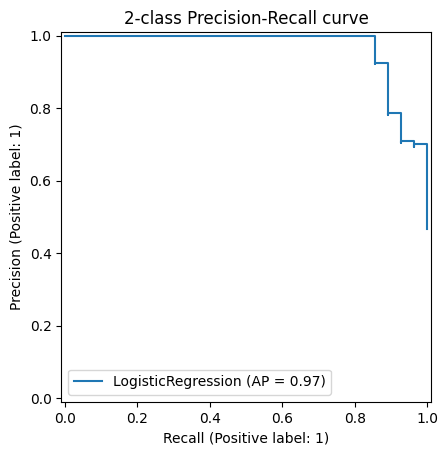

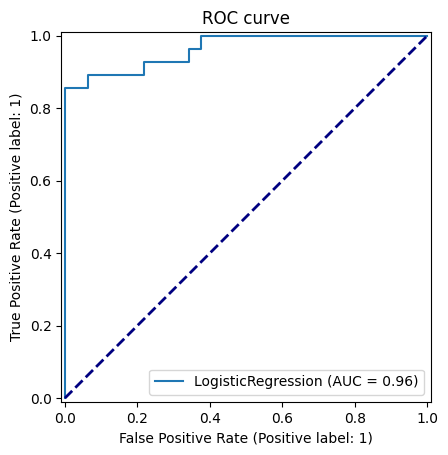

In [23]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, accuracy_score

# Построение Precision-Recall кривой
disp = PrecisionRecallDisplay.from_estimator(logreg, X_test, y_test)
disp.ax_.set_title("2-class Precision-Recall curve")
plt.show()

# Построение ROC кривой
RocCurveDisplay.from_estimator(logreg, X_test, y_test)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.title("ROC curve")
plt.show()

In [24]:
# Настройка порога принятия решения
thresholds = np.arange(0.1, 0.9, 0.1)
best_threshold = None
best_recall = 0

y_pred_ = logreg.predict(X_test)
y_probs_ = logreg.predict_proba(X_test)[:, 1]
best_y_pred_threshold = 0

for threshold in thresholds:
    y_pred_threshold = (y_probs_ >= threshold).astype(int)
    recall_threshold = recall_score(y_test, y_pred_threshold)
    if recall_threshold > best_recall:
        best_recall = recall_threshold
        best_threshold = threshold
        best_y_pred_threshold = y_pred_threshold

print(f"Best threshold: {best_threshold:.2f}")
print(f"Best recall: {best_recall:.2f}")

Best threshold: 0.10
Best recall: 1.00


# Посмотрим на остальные метрики при максимальной полноте

In [25]:
precision_ = precision_score(y_test, best_y_pred_threshold)
recall_ = recall_score(y_test, best_y_pred_threshold)
f1_ = f1_score(y_test, best_y_pred_threshold)
accuracy_ = accuracy_score(y_test, best_y_pred_threshold)


print(f"Precision: {precision_:.2f}")
print(f"Recall: {recall_:.2f}")
print(f"F1 Score: {f1_:.2f}")
print(f"Accuracy: {accuracy_:.2f}")

Precision: 0.61
Recall: 1.00
F1 Score: 0.76
Accuracy: 0.70


# Заключение

Данные прошли тщательную предобработку. Обучено несколько моделей, выбрана наилучшая (логистическая регрессия). Все модели оценены по различным метрикам. Был применен подход предсказания, который настраивает модель таким образом, чтобы минимизировать количество пропущенных больных пациентов, при этом отслеживая другие важные метрики для общей оценки производительности модели.